In [1]:
from scipy import stats
from Models import Model
import numpy as np
import ABC

# silence warnings about dodgy division
np.seterr(divide='ignore', invalid='ignore')

# Size plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# SIR Modelling and ABC
*Compartmental Models* are a class of mathematical models used for modelling infectious diseases where each member of the population are assigned to different classes. The SIR Model is a compartmental model where members of the population are either **S**usceptible, **I**nfectious or **R**ecovered.

**Table of Contents**
 * [Motivation](#Motivation)
 * [The SIR Model](#The-SIR-Model)
   * [Specification](#Specification)
   * [Implementation](#SIR-Implementation)
   * [Discussion](#Discussion)
 * [SIR and ABC](#SIR-and-ABC)
   * [Implementation](#SIR-and-ABC-Implementation)
     * [ABC-Rejection Algorithm](#ABC-Rejection-Algorithm)
     * [ABC-MCMC](#ABC-MCMC)
     * [ABC-SMC](#ABC-SMC)
   * [Better Summary Statistics](#Better-Summary-Statistics)
     * [Peaks](#better_ss_peaks)
     * [Acutal Peak](#better_ss_acutal_peak)
   * [Discussion](#Discussion_SIR_and_ABC)

## Motivation

## The SIR Model
Here I present the classical SIR model which uses ordinary differential equations.

### Specification

Compartmental models are used to model individuals in a population. Each model defines a set of classes which partition the population and defines the mechanics by which individuals can move between populations. Compartmental models are often used to model the spread of something through a population, notably infectious diseases.

I shall present the SIR model for the problem of modelling infectious diseases.

**Classes**

The SIR model is one of the simpliest (but still powerful) compartmental models which uses three classes:
 * **S**usceptible - Individuals who do not currently have the disease, but could catch it if they came into contact with an infectious person.
 * **I**nfectious - Individuals who currently have the disease and are able to spread it.
 * **R**emoved - Individuals who have had the disease in the past and are no longer at risk of infection (either due to death or recovery).

For simple models it is assumed that the total population size is constant and no-one enters or leaves the population.

In this case of a deadly infectious disease we want to move as many people from the susceptible set to the removed set whilst minimising deaths (A subset of the removed set).

**Dynamics**

In the simplest SIR only two transitions are modelled

$$ \text{Susceptible}\to\text{Infectious}\to\text{Removed} $$

In more complicated models other transitions are considered such as $ \text{Susceptible}\to\text{Removed} $ due to a vaccination or $ \text{Removed}\to\text{Susceptible} $ due to immunity wearing off.

Under the simplest SIR model the transition rate per time-period of $ \text{Susceptible}\to\text{Infectious} $ is stated mathematically as
$$ \frac{dS}{dt}=-\beta\frac{SI}{N} $$
where
 * $\beta$ is the average number of contacts for each infected person in a single time-period multiplied by the probability of a contact becoming infected.
 * $N$ is the total population size.
This result is derived similarly to the *Law of Mass Action* which considers random collision between molecules in chemical reactions.
 
The transition rate per time-period of $ \text{Infectious}\to\text{Removed} $ is stated mathematically as
$$ \frac{dI}{dt}=-\gamma I $$
where
 * $\gamma$ is the probability of an individual who is infectious becoming no-longer infectious in a given time-period (either due to death or recovery).
 
With these two transitions we can fully state the SIR model with the following set of ODEs
$$\begin{array}{rcl}
    \frac{dS}{dt}&=&-\beta\frac{IS}{N}\\
    \frac{dI}{dt}&=&\beta\frac{IS}{N}-\gamma I\\
    \frac{dR}{dt}&=&\gamma I
\end{array}$$

Due to the model not allowing for individuals to leave or enter the population, the following results hold
$$\begin{array}{rcl}
    \frac{dS}{dt}+\frac{dI}{dt}+\frac{dR}{dt}&=&0\\
    S(t)+I(t)+R(t)&=&N
\end{array}$$

<a id="SIR-Implementation"></a>
### Implementation
First I implement a deterministic version of the SIR model described [above](#Specification). This is deterministic as the parameters $\beta,\gamma$ are taken to be deterministic rather 

In [2]:
class SIRModel(Model):

    def __init__(self,params:(int,float,float),n_obs:int):
        """
        DESCRIPTION
        Classical SIR model

        params ((int,int,float,float)) - (population_size,initial_infectied_population_size,beta,gamma)
        n_obs (int) - number of time-periods to run model for
        """

        if (params[0]<params[1]): raise ValueError("Number of initially infected individuals cannot be greater than the population size.")

        # all models have the following
        self.n_params=4
        self.population_size=params[0]
        self.initially_infected=params[1]
        self.beta=params[2]
        self.gamma=params[3]
        self.params=params # parameter values

        self.param_labels=["Susceptible","Infectious","Removed"]

        self.n_obs=n_obs # number of observations made by `observe`
        self.dim_obs=3 # dimension of each observation

        self.noise=0 # variance of additive gaussian noise (default=0)

        self.observations=self.__calc()

    def update_params(self,new_params:[float]):
        """
        DESCRIPTION
        update the parameters of the model. the observations for `observe` need to be recalculated

        PARAMETERS
        new_paramas ([float]) - new parameter values
        """
        if (len(new_params)!=self.n_params): raise ValueError("Incorrect number of parameters passed. len(params)!=n_params.")

        self.population_size=new_params[0]
        self.initially_infected=new_params[1]
        self.beta=new_params[2]
        self.gamma=new_params[3]

        self.observations=self.__calc()

    def observe(self,inc_noise=True) -> [[float]]:
        """
        DESCRIPTION
        generate a sequence of `n_obs` observations from the model, each of dimension `dim_obs`.
        The same sequence is returned each time this function is called.
        sequence is ordered by `x_obs` so is best for `x_obs` to provide a useful ordering.

        PARAMETERS
        None

        RETURNS
        [[float]] - sequence of observations
        """
        return self.observations

    def __calc(self) -> [(int,int,int)]:
        """
        DESCRIPTION
        calculate the time-series of observations from the specified SIR model (using ODEs)

        RETURNS
        [(int,int,int)] - time-series with each data-point being (S,I,R)
        """
        observations=[(self.population_size-self.initially_infected,self.initially_infected,0)] # [(S,I,R)]

        for t in range(self.n_obs-1):
            last_obs=observations[-1]

            new_infections=int(self.beta*((last_obs[0]*last_obs[1])/self.population_size))
            new_removed   =int(self.gamma*last_obs[1])

            d_S=-new_infections
            d_I=new_infections-new_removed
            d_R=new_removed

            new_obs=(last_obs[0]+d_S,last_obs[1]+d_I,last_obs[2]+d_R)
            observations.append(new_obs)

        return observations

    def copy(self,new_params:[float]) -> "Model":
        """
        DESCRIPTION
        create a copy of the model with new parameter values

        PARAMETERS
        new_params ([float]) - new parameter values

        RETURNS
        Model - New copy, with stated parameter values
        """
        if (type(new_params)!=list): raise TypeError("`new_params` shoud be a list (not {})".format(type(new_params)))
        if (len(new_params)!=self.n_params): raise TypeError("`new_params` shoud of length `n_params` ({})".format(self.n_params))

        new_model=SIRModel(new_params,self.n_obs)
        return new_model

    def __str__(self) -> str:
        printing_str="Population Size={:,.1f}\n".format(self.population_size)
        printing_str+="Initially Infected={:,.1f}\n".format(self.initially_infected)
        printing_str+="Beta={:.3f}\n".format(self.beta)
        printing_str+="Gamma={:.3f}".format(self.gamma)

        return printing_str

For demonstration, below I use my `SIRModel` class to define an SIR model for a population of size 100,000 with 100 initially infected people where each infected person infects one susceptible person per day and each day half the infectious people become removed (i.e. average infection lasts 2 days). I run the model over 30 days.
<a id="sir_model_specified"></a>

Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500


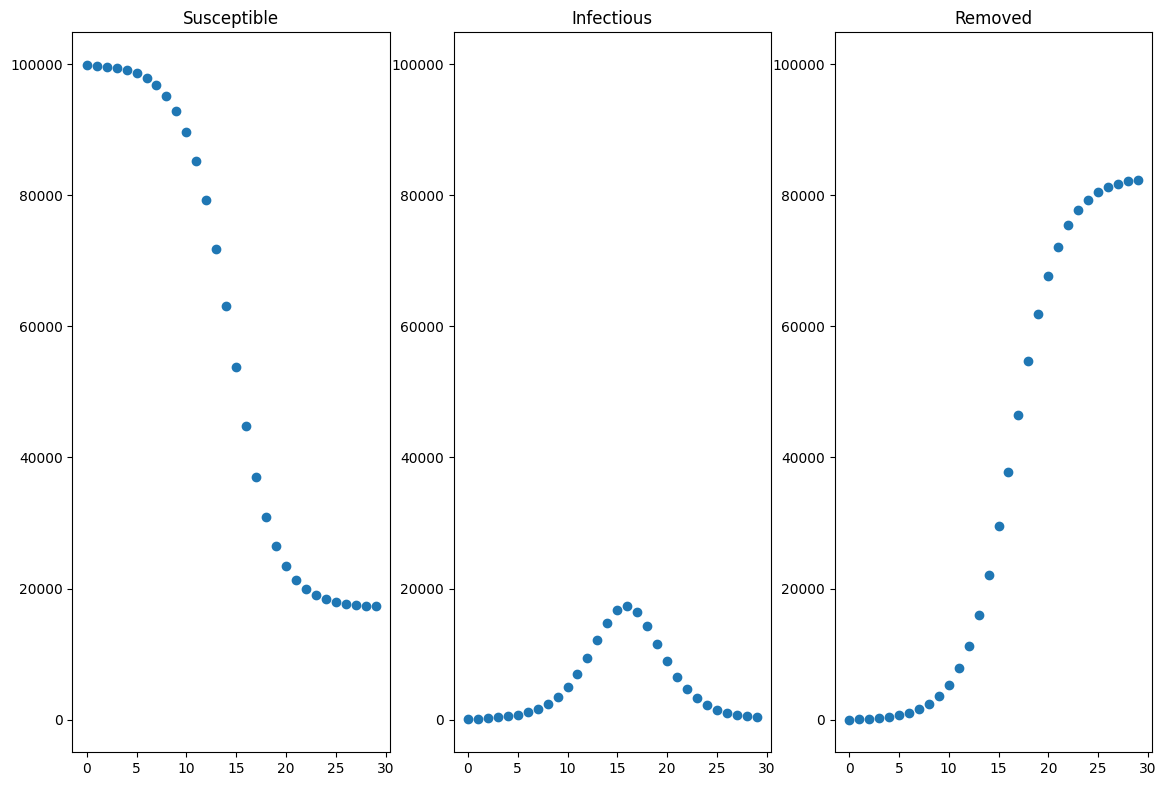

In [3]:
sir_model=SIRModel(params=[100000,100,1,.5],n_obs=30)
print(sir_model)
sir_model.plot_obs(constant_scale=True)

These plots above show that under these conditions
 * The size of the infectious population never exceeds 20,000.
 * The pandemic is almost complete after the 30 days.
 * ~80% of the population ends up being removed. Meaning ~80% of the population become infected in this 30 day period.

## Discussion

Limitations
 * TODO

Extensions
 * Stochastic SIR model
 * Non-constant population size
 * $\beta,\gamma$ vary over time (ie seasonally).

## SIR and ABC

<a id="SIR-and-ABC-Implementation"></a>
### Implementation
Here I run all three of the ABC algorithms which were discussed in [ABC_Notebook](ABC_Notebook.ipynb) on the classical SIR model described [above](#sir_model_specified) (ABC-Rejection Sampling, ABC-MCMC and ABC-SMC).

For all three algorithms I use the same set of priors and summary statistics:
 * For total population size $N$ and the intial number of infectious people $I(0)$ I set the priors st the true value is always returned as it is reasonable for these values to be known to a high degree of accuracy in real-world scenarios.
 * For $\beta,\gamma$ I defined the priors below. These priors where chosen as their means are not the true values so the parameters so some learning needs to occur for a good fit to occur. I had to make the priors fairly narrow to avoid overflow errors in my implementation.
 $$ \pi_0(\beta)\sim\mathcal{U}[0,1.5]\quad\pi_0(\gamma)\sim\mathcal{U}[0,2] $$
 * For the summary statistics I naively use the identity function. In practice this means that each time-point of the simualted time-series is compared to the equivalent time-point in the observed time-series. 

**ABC-Rejection Sampling**
 * The *Best Samples* variation is used. This reduces the amount of tuning which needs to be done.
 * Ran 10,000 simulations and then use the best 100 to fit the model.

**ABC-MCMC**
 * The perturbance kernels adds additive gaussian noise with mean $0$ and variance $\sigma^2=.1$ to $\beta,\gamma$. No change occurs to $N$ or $I(0)$ as their true values are provided to the algorithm. I chose $\sigma^2$ completely arbitraly.
 * A gaussian acceptance kernel is used with bandwidth $\varepsilon=20,000$. I tweaked this value until ~5% of all perturbances were accepted.
 
**ABC-SMC**
 * The same perturbance kernel is used as in ABC-MCMC.
 * A sequence of 3 bandwidths are used, equally spaced from 50,000 to 15,000.
 * A sample size of 25 is used.
 * The bandwidths and sample size were chosen st the run-time of this algorithm was similar to the other two.
 * Due to technical reasons around how `scipy.stats.uniform.pdf` is implemented, I have to define proper priors for population size $N$ and number of initial infectees $I(0)$ in order to avoid null values which cause problems when calculating the weight for each sample point (without having to do a significant rework to my implementation). As I have defined these priors to be extremely narrow, this results in no practical changes to the performance of the algorithm.
 
*I comment on the performance of each algorithm after they are run.*

### ABC-Rejection Algorithm

(9,999/10,000)



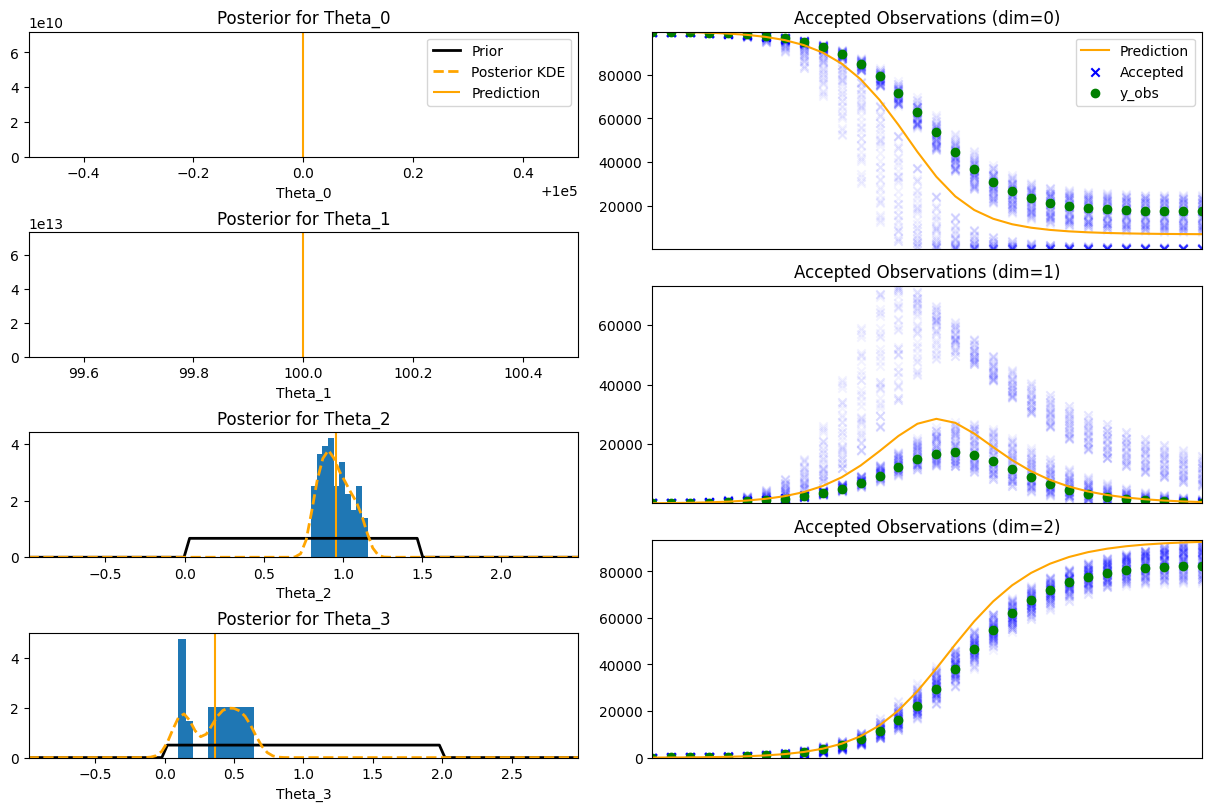

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
Fitted Model - Population Size=100,000.0
Initially Infected=100.0
Beta=0.954
Gamma=0.364

Wall time: 7.47 s


In [4]:
%%time
# ABC-Rejection Sampling (Best Samples)
np.random.seed(16111998) # Fix random seed
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]

sampling_details={"sampling_method":"best","num_runs":10000,"sample_size":100}
fitted_model=ABC.abc_rejcection(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,sampling_details=sampling_details)
print("True Model - {}".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The fitted model has parameter values $\hat\beta=0.954$ and $\hat\gamma=0.364$. This shows a very good fit for $\beta$ but less good for $\gamma$. This is overall a good fit, especially since it took less than 10 seconds. A better fit could likely be achieved without requiring greater computational resources by fiddling with the algorithm parameters (Namely number of simualtions and proportion accepted).

Observing the plots of accepted simulated values (RHS) it is interesting how the plots for the susceptible (dim=0) and infected (dim=1) populations have a significant number of accepted simulations which are very close to the observed values but also a large number which deviate significantly (but all in a similar way). This would suggest that either increasing the number of simulations being run or decreasing the proportion of simulations being used to fit the model would very quickly improve the model fit.

It is notable that the plot the removed population (dim=2) does not show this property, likely suggesting that small changes in $\beta$ have a greater affect on the model than small changes in $\gamma$. This is worth exploring further.

The posteriors for $\beta,\gamma$ ($\theta_2,\theta_3$ respectively) do show that a significant amount of mass is placed near the true values of each parameter, showing that significant learning has occured.

### ABC-MCMC

Found Start - (251) [100000.0, 100.0, 1.0408154202789652, 0.5330237701348413]
0.042 observations were new.


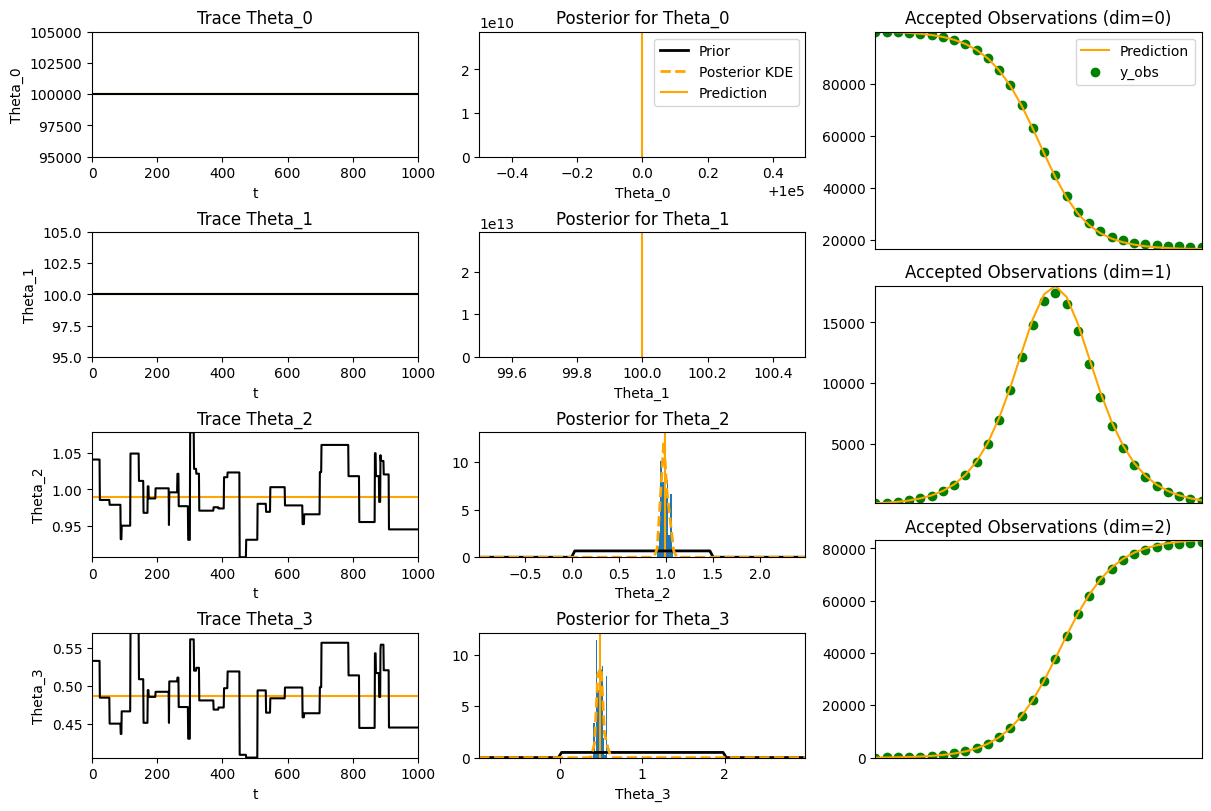

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
Fitted Model - Population Size=100,000.0
Initially Infected=100.0
Beta=0.990
Gamma=0.487

Wall time: 5.2 s


In [5]:
%%time
# ABC-MCMC
np.random.seed(16111998) # Fix random seed
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2

fitted_model=ABC.abc_mcmc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,
    chain_length=1000,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.gaussian_kernel,scaling_factor=20000)
print("True Model - {}".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The fitted model has parameter values $\hat\beta=0.990$ and $\hat\gamma=0.487$. This is an almost perfect fit, which is clear from the plots of the fitted model against the observed model (RHS). The initial burn-in took 251 simulations and of the 1,000 perturbances in the MCMC-step only 4.2% were accepted.

For this model, the performance of ABC-MCMC is signficantly better than ABC-Rejection Sampling and the difference is notably greater than it was for the linear and exponential models tested in [ABC_Notebook](ABC_Notebook.ipynb). Moreover, not only is the fitted model significantly close to the true model, ABC-MCMC used ~10% of the simulations that ABC-Rejection Sampling used (1,251 vs 10,000) and ran notably quicker (5.48s vs 7.06s) demonstrating its greater computational efficiency.

A concern from these results is how few samples were accepted, but this can be controlled by tuning the bandwidth and kernel used by the algorithm.

Again, the posteriors (middle col.) have their mass concentrated close to the true value of each parameter and are significantly different shapes than the priors, showing that significant learning has occurred.

### ABC-SMC

(2,035) - 25/25
(2/3 - 1,723) - 24/25 (15000.000)
Total Simulations - 4,307
theta_hat - [100000.00586584197, 100.00341703998242, 1.000066767889438, 0.4839657563166918]


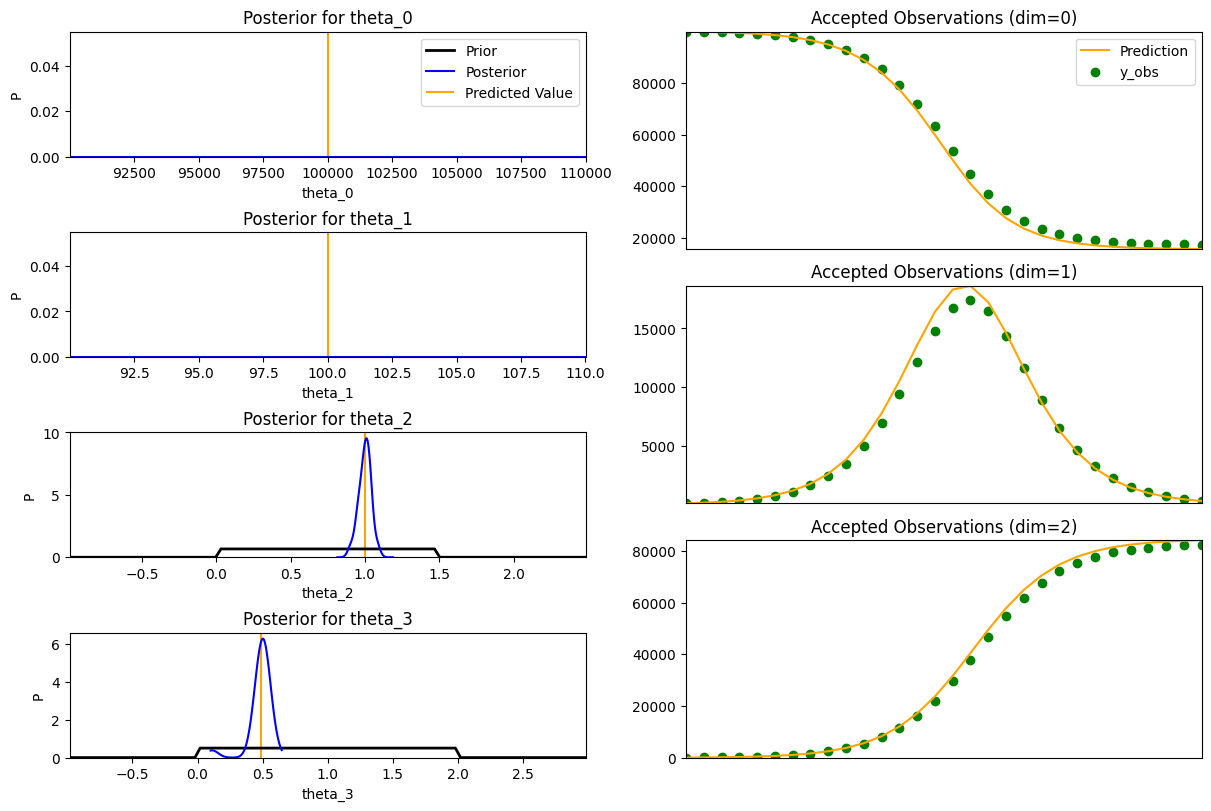

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
Fitted Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.484

Wall time: 17.2 s


In [6]:
%%time
# ABC-SMC
np.random.seed(16111998) # Fix random seed
sir_priors=[stats.uniform(100000,.01),stats.uniform(100,.01),stats.uniform(0,1.5),stats.uniform(0,2)]
scaling_factors=list(np.linspace(50000,15000,3))

perturbance_variance=.1
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:1]*2 + [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]*2

fitted_model=ABC.abc_smc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,
    num_steps=3,sample_size=25,scaling_factors=scaling_factors,perturbance_kernels=perturbance_kernels,
    perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel)

print("True Model - {}".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The fitted model has parameter values $\hat\beta=1.000$ and $\hat\gamma=0.484$, similar to ABC-MCMC, this is an almost perfect fit. The initial sample took 2,035 simulations and a total of 4,307 simulations were performed.

The final fit is practically the same as from ABC-MCMC but ABC-SMC took 3 times the number of simulations and approximately twice as long to execute. Suggesting that ABC-MCMC is better suited to fitted a classical SIR model but that may not be true after tuning and under different priors etc.

As with the other two algorithms, the posteriors (LHS) have their mass concentrated close to the true value of each parameter and are significantly different shapes than the priors, showing that significant learning has occurred.

### Better Summary Statistics

<a id="better_ss_peaks"></a>
**Peaks**

In *Approximate Bayesian Computation for infectious disease modelling* Minter and Retkute suggest three sets of summary statistics
<ol>
    <li>Identity function (As I used <a href="#Implementation">above</a>).</li>
    <li> $\{R(29)\}$ - The size of the removed population on the final day.</li>
    <li> $\{I(16),R(29)\}$ - The size of the infectious and removed populations on the days of their respective peaks in the observed data.</li>
</ol>

Below I implement and use sets 2. and 3. with the ABC-MCMC algorithm. In both cases I use a gaussian kernel with bandwidths $\varepsilon_1=600$ and $\varepsilon_2=1,500$, these values are tuned st ~5% of simulations in the MCMC step are accepted. I have kept the chain length at 1,000 so that these results can be compared with [above](#ABC-MCMC).

In [7]:
# Define the summary stats
removed_peak_ss=(lambda ys:[ys[29][2]])
infected_peak_ss=(lambda ys:[ys[16][1]])

<a id="better_ss_1"></a>

Found Start - (164) [100000.0, 100.0, 0.737927186251722, 0.3187006097864149]
0.048 observations were new.


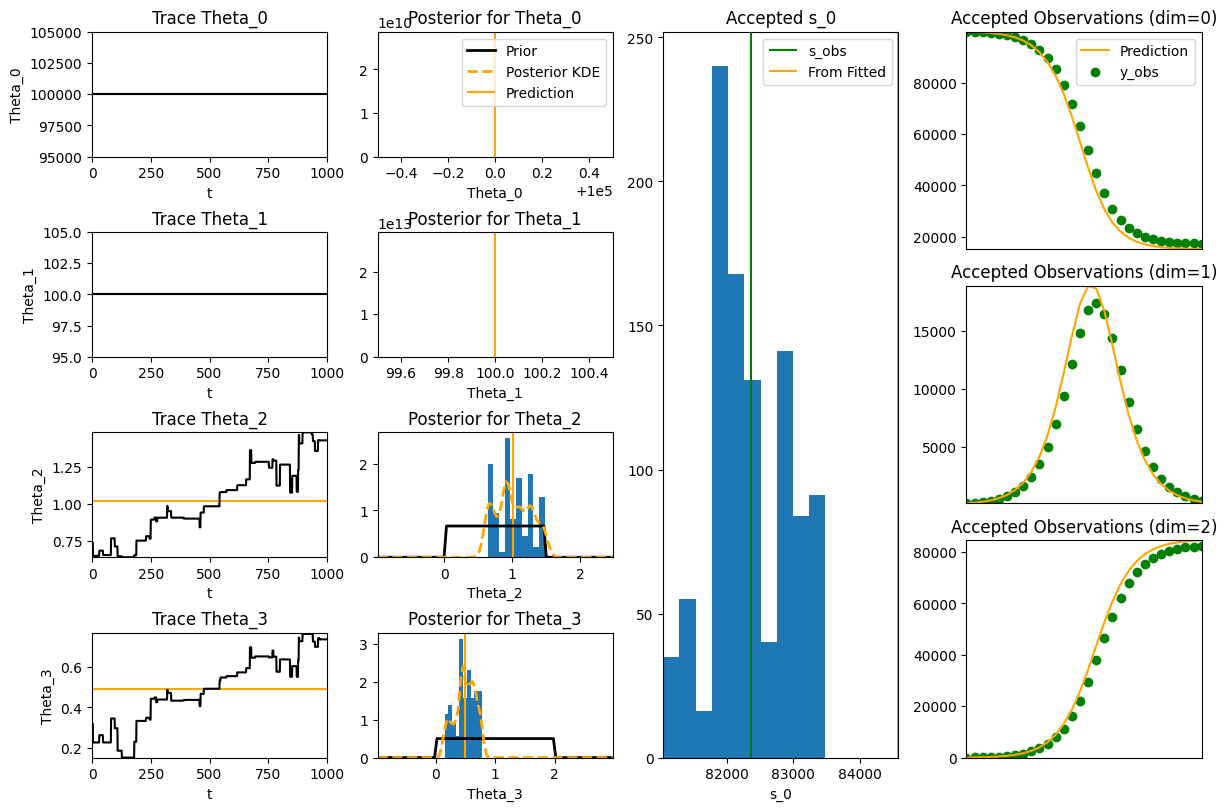

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
Fitted Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.018
Gamma=0.490

Wall time: 5.59 s


In [8]:
%%time
# ABC-MCMC \w R peak
np.random.seed(16111998) # Fix random seed
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2

fitted_model=ABC.abc_mcmc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,
    chain_length=1000,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.gaussian_kernel,scaling_factor=600,
    summary_stats=[removed_peak_ss])

print("True Model - {}".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The fitted model has parameter values $\hat\beta=1.018$ and $\hat\gamma=0.490$ and required a burn in of 164 simulations. This is a very good fit, moreover it is as good as any of fitted models produced by the earlier algorithms despite only comparing 1 data-point per simulation rather than 90.

The traces (LHS) of the MCMC step show that the algorithm had not converged by the end of the 1,000 simulations so more simulations would likely improve its confidence/consistency. This lack of convergence is reitrated by the posteriors (col. 2) and histogram (col. 3) not being as concentrated as the previous running of [ABC-MCMC](#ABC-MCMC).

<a id="better_ss_2"></a>

Found Start - (164) [100000.0, 100.0, 0.737927186251722, 0.3187006097864149]
0.045 observations were new.


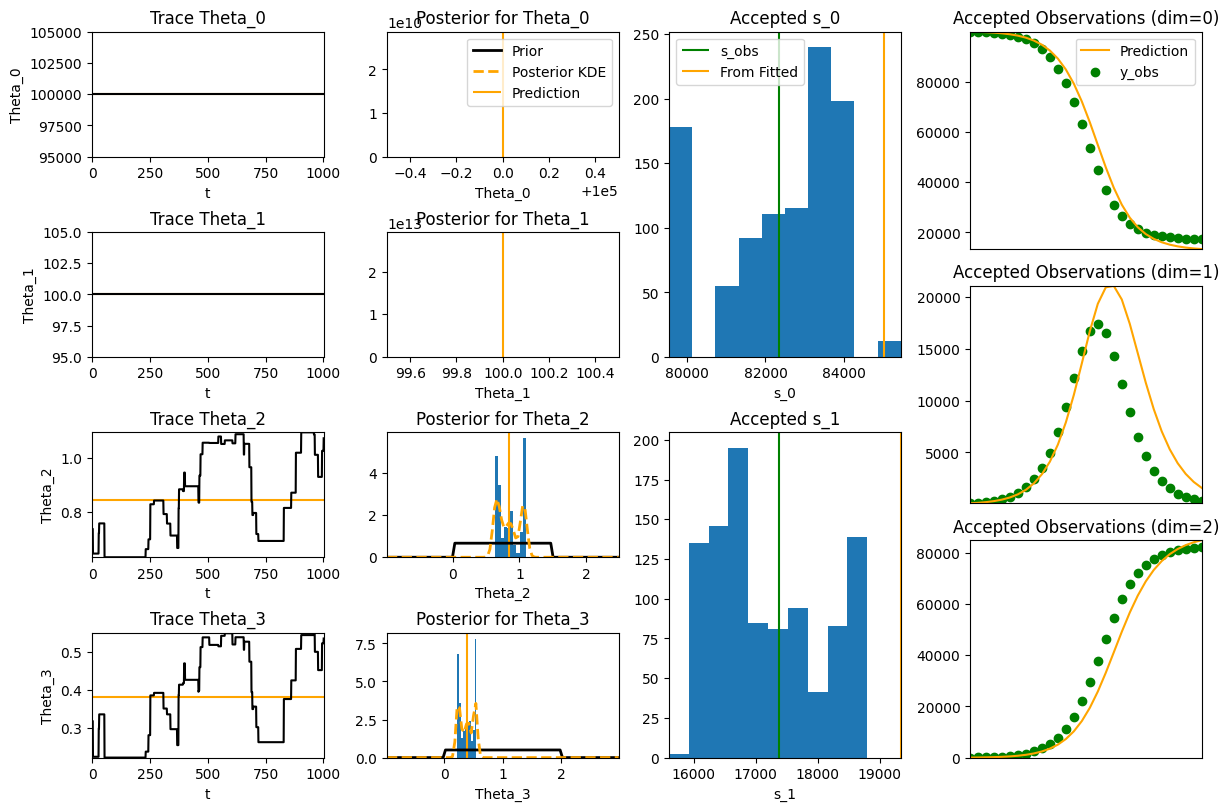

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
Fitted Model - Population Size=100,000.0
Initially Infected=100.0
Beta=0.845
Gamma=0.381

Wall time: 5.98 s


In [9]:
%%time
# ABC-MCMC \w I AND R peak
np.random.seed(16111998) # Fix random seed
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2

fitted_model=ABC.abc_mcmc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,
    chain_length=1000,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.gaussian_kernel,scaling_factor=1500,
    summary_stats=[removed_peak_ss,infected_peak_ss])
print("True Model - {}".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The fitted model has parameter values $\hat\beta=0.845$ and $\hat\gamma=0.381$. This is a notably worse fit than above [above](#better_ss_1), despite this run using an extra summary statistic which utilises different information.

Again, the posteriors (LHS), traces (col 2.) & histograms (col 3.) show that convergence has not occurred in this running of the algorithm.

Interestingly, the peak of the infectious population in the fitted model occurs later than in the observed model and has a greater value. This is likely due to the new summary statistic `infected_peak_ss` actually only considering the size of the infected population on the 17th day, and doesn't actually consider when the peak occurs or what its value is. I would be interested to see how a set of summary statistics which considered these two values performed.

<a id="better_ss_acutal_peak"></a>
**Actual Peak**

I propose the following set of summary statistics
<ol>
    <li>Date of peak of infectious population.</li>
    <li>Peak size of infectious population.</li>
</ol>
So that these statistics are approximately equally weighted I multiply 1. by 1,000 as the peak date sound be ~16 and the peak infected population ~17,500.

I tunned the bandwidth to be $\varepsilon=1,000$ as this meant ~5% of simulations in the MCMC step were accepted.

In [10]:
# Define summary statistics
peak_infections_date_ss=(lambda ys:[1000*ys.index(max(ys,key=lambda y:y[1]))])
peak_infections_value_ss=(lambda ys:[max(ys,key=lambda y:y[1])[1]])

Found Start - (251) [100000.0, 100.0, 1.0408154202789652, 0.5330237701348413]
0.052 observations were new.


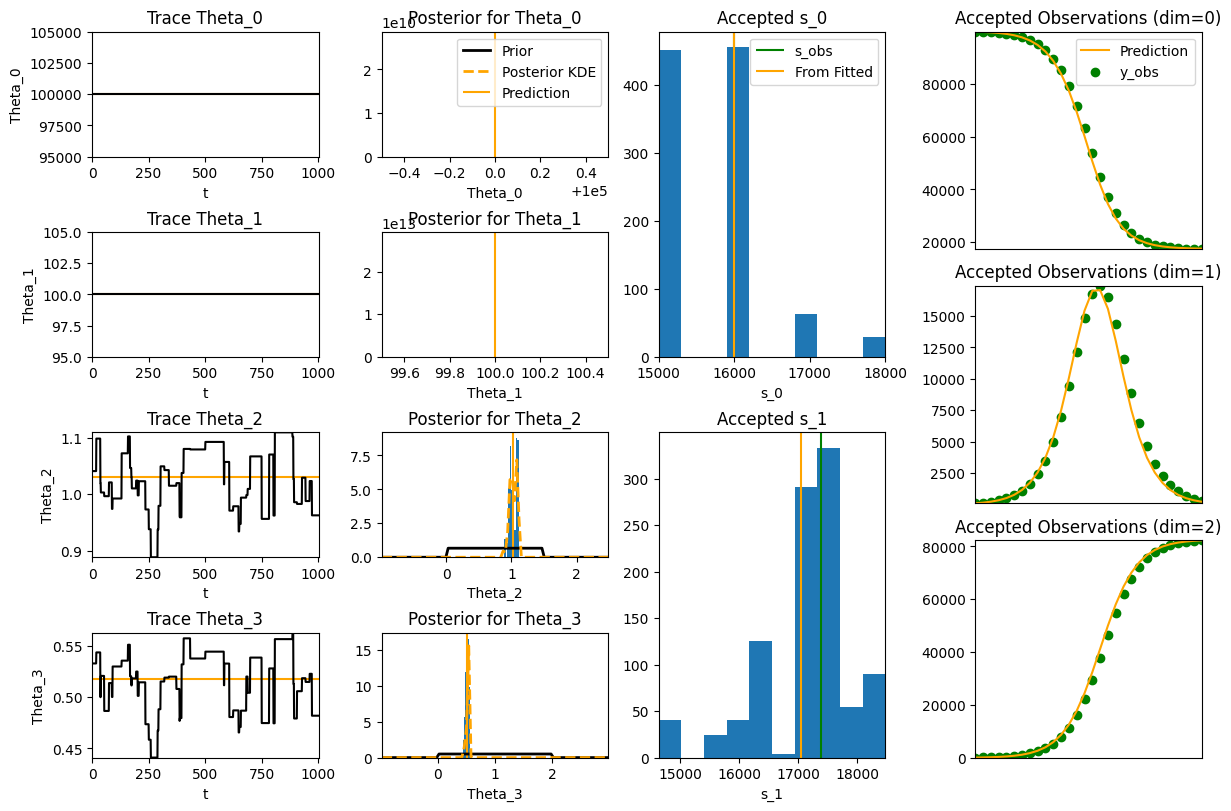

True Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.000
Gamma=0.500
Fitted Model - Population Size=100,000.0
Initially Infected=100.0
Beta=1.030
Gamma=0.518

Wall time: 6.31 s


In [13]:
%%time
# ABC-MCMC \w I peak value & date
np.random.seed(16111998) # Fix random seed
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2

fitted_model=ABC.abc_mcmc(n_obs=30,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,
    chain_length=1000,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.gaussian_kernel,scaling_factor=1000,
    summary_stats=[peak_infections_date_ss,peak_infections_value_ss])
print("True Model - {}".format(sir_model))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The fitted model has parameter values $\hat\beta=1.030$ and $\hat\gamma=0.518$. This is a very good fit, approximately as good as the fit [above](#better_ss_1) when only using the peak size of removed population.

The notable improvement of using these two summary statistics over just the peak size of the removed population is that the MCMC chain (LHS) seems much closer to convergence in this case. This is emphasised by the concentration of mass in the posteriors (col 2.) and histograms (col 3.).

This set of summary statistics act almost optimally in both fit and rate of convergence.

<a id="Discussion_SIR_and_ABC"></a>
### Discussion

Limitations/when problems arrise (e.g. auto-correlation).